# Imports

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models import NN, CNN

DATA_FOLDER = 'data/'

# NN

In [2]:
model = NN(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.to(model.device), val_target.to(model.device)

######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target, num_epochs=1000, val_lags=val_lags, val_target=val_target)

######################### Validation: #########################
model.load_pretrained_model()
model.test(val_lags, val_target)

Training model: 100%|██████████| 1000/1000 [00:00<00:00, 1392.34 epoch/s]


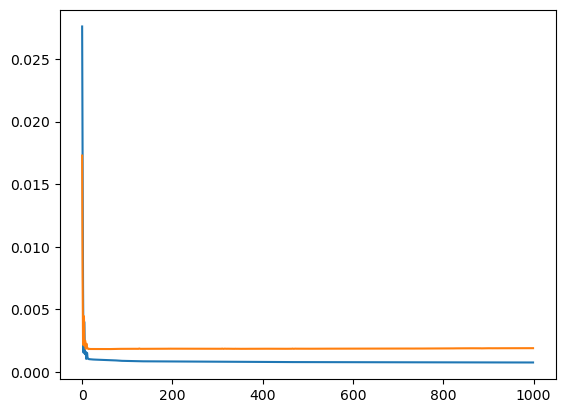

In [3]:
######################### Plot losses: #########################
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.show()

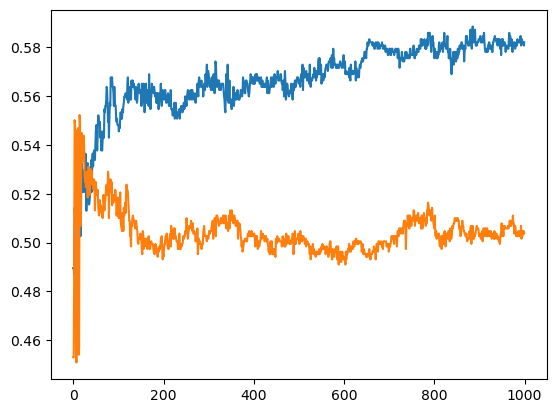

In [4]:
plt.plot(model.train_hit_rates)
plt.plot(model.val_hit_rates)

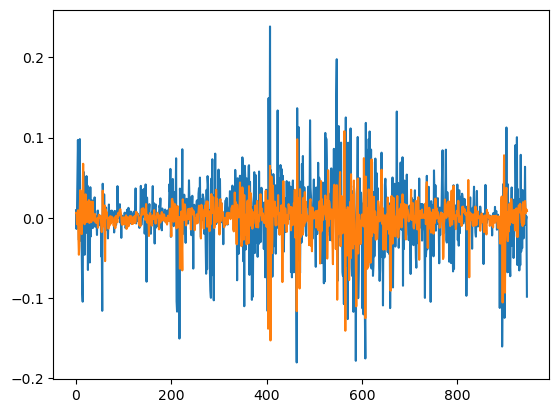

In [5]:
plt.plot(val_target.to('cpu'))
plt.plot(model.forecast(val_lags).to('cpu').detach())
plt.show()

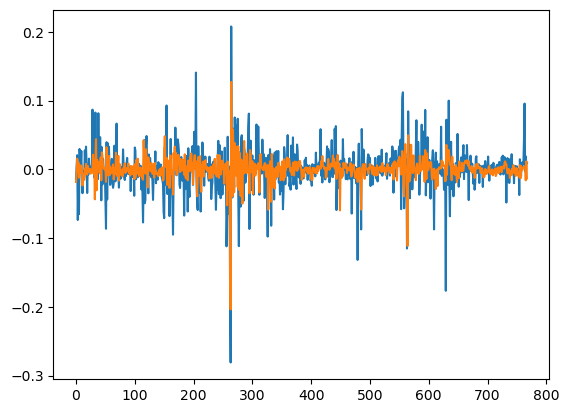

In [6]:
plt.plot(train_target.to('cpu'))
plt.plot(model.forecast(train_lags).to('cpu').detach())
plt.show()

Training model: 100%|██████████| 50/50 [00:00<00:00, 1281.13 epoch/s]


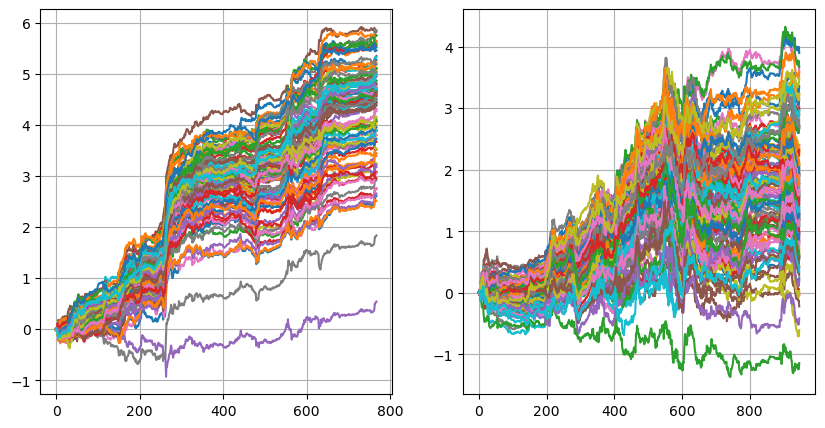

0.5258289349079132
0.7515902291222516
0.7400055202730682


In [9]:
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(nb_model):
    model = NN(nb_lags=6, lr=1e-2)
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)
    model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)

# CNN

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models import NN, CNN

DATA_FOLDER = 'data/'

/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = CNN(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.to(model.device), val_target.to(model.device)

######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)

######################### Validation: #########################
model.load_pretrained_model()
model.test(val_lags, val_target)

Training model: 100%|██████████| 35/35 [00:00<00:00, 41.91 epoch/s]


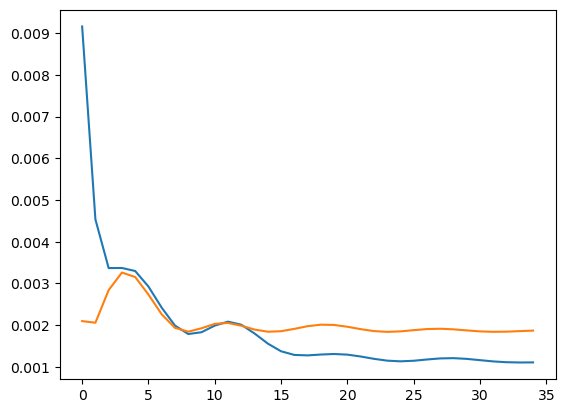

In [9]:
######################### Plot losses: #########################
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.show()

Training model: 100%|██████████| 35/35 [00:00<00:00, 46.44 epoch/s]


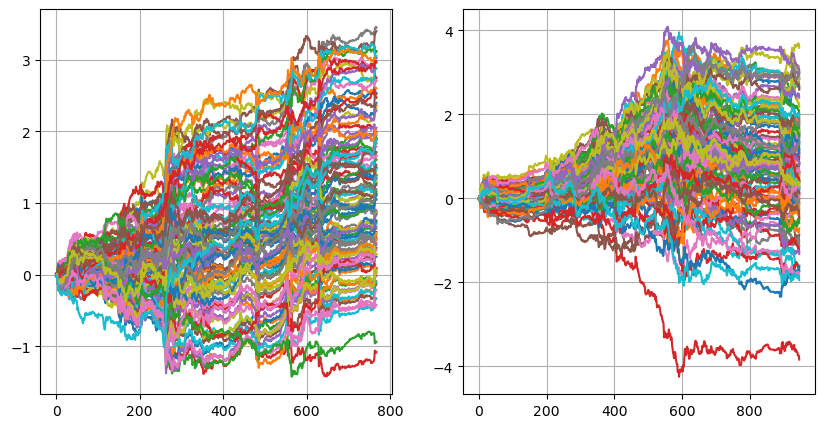

0.5228194278478623
0.810670284358599
0.3518407014468805


In [5]:
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(nb_model):
    model = CNN(nb_lags=6, lr=1e-2)
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)
    model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)

# Number of parameters

In [2]:
model = NN(nb_lags=6, lr=1e-2)
print("NN: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

model = CNN(nb_lags=6, lr=1e-2)
print("CNN: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

NN:  67
CNN:  69
